In [1]:
from qaravan.core import TFI, brickwall_skeleton, RunContext, ChiralHeisenberg, Gate, Circuit, two_local_circ, CNOT, H, Circuit, pauli_X, pauli_Y, pauli_Z, embed_operator, string_to_sv
from qaravan.tensorQ import environment_state_prep, StatevectorSim, all_zero_sv, random_sv
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy
from functools import reduce

In [2]:
from qaravan.core.param_gates import *

def tfi_hva(params, num_sites): 
    backend = "torch" if torch.is_tensor(params) else "numpy"
    zz = zzN if backend == "numpy" else zzT
    x = pauli_X if backend == "numpy" else pauli_XT 
    expm = scipy.linalg.expm if backend == "numpy" else torch.matrix_exp

    num_layers = len(params) // 2
    gate_list = [H(i) for i in range(num_sites)]
    for k in range(num_layers): 
        zrot = expm(-1j * params[2*k] * zz)
        for i in range(0, num_sites, 2):
            gate = Gate('R2', [i, i + 1], zrot)
            gate_list.append(gate)
        for i in range(1, num_sites, 2):
            gate = Gate('R2', [i, (i + 1)%num_sites], zrot)
            gate_list.append(gate)

        xrot = expm(-1j * params[2*k + 1] * x)
        for i in range(num_sites):
            gate = Gate('R1', [i], xrot)
            gate_list.append(gate)
    
    return Circuit(gate_list, num_sites)

def tfi_hva_cost(params, num_sites, target_sv): 
    circ = tfi_hva(params, num_sites)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return 1 - torch.abs(torch.dot(ansatz_sv.conj(), target_sv))**2

def tfi_hva_energy(params, num_sites, ham_mat):
    circ = tfi_hva(params, num_sites)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return (torch.dot(ansatz_sv.conj(), torch.mv(ham_mat, ansatz_sv))).real

def optimize_func(cost_func, params, cost_args=(), opt_kwargs=None, sch_kwargs=None, context=None):
    opt_kwargs = opt_kwargs or {'lr':0.1, 'weight_decay':1e-4}
    sch_kwargs = sch_kwargs or {'mode':'min', 'factor':0.1, 'patience':200, 'threshold':1e-4, 'threshold_mode':'rel'}

    if not isinstance(params, torch.nn.Parameter):
        params = torch.nn.Parameter(params)

    optimizer = torch.optim.AdamW([params], **opt_kwargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **sch_kwargs)

    if context is None:
        context = RunContext(
            progress_interval=2,
            max_iter=10000,
            checkpoint_file=None,
            checkpoint_interval=100,
            resume=False,
            convergence_check=True,
            stop_ratio=1e-6
        )

    cost_list = []
    run_state = {
        "cost_list": cost_list,
        "step": context.step
    }

    while True:
        cost = cost_func(params, *cost_args)
        cost_val = cost.item()
        cost_list.append(cost_val)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(cost_val)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"[LR Drop] Step {run_state['step']}: cost = {cost:.2e}, LR dropped from {old_lr:.2e} to {new_lr:.2e}")

        run_state["step"] += 1

        if context.step_update(run_state):
            break

    return cost_list, params

In [6]:
n = 14

critical_ham = TFI(n, 1, 0.5, periodic_x=True)
ge, gs = critical_ham.ground()
target_sv = torch.tensor(gs[:,0])

num_layers = 7
num_params = 2 * num_layers
params = torch.tensor(np.random.rand(num_params))
cost_func = tfi_hva_cost
opt_kwargs = {'lr': 0.1, 'weight_decay': 1e-4}
sch_kwargs = {'mode': 'min', 'factor': 0.1, 'patience': 100}

cost_list, params = optimize_func(cost_func, params, (n, target_sv), opt_kwargs=opt_kwargs, sch_kwargs=sch_kwargs) 

plt.plot(cost_list)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('infidelity')

KeyboardInterrupt: 

Step 100 at 2025-06-03T12:12:37 with cost -1.306546452805938
Step 200 at 2025-06-03T12:12:37 with cost -1.3065629639110634
Step 300 at 2025-06-03T12:12:37 with cost -1.3065629648273716
Step 400 at 2025-06-03T12:12:38 with cost -1.3065629648415547
Step 500 at 2025-06-03T12:12:38 with cost -1.306562964849876
Step 600 at 2025-06-03T12:12:38 with cost -1.306562964855403
Step 700 at 2025-06-03T12:12:39 with cost -1.3065629648593322
Step 800 at 2025-06-03T12:12:39 with cost -1.306562964862251
Step 900 at 2025-06-03T12:12:39 with cost -1.3065629648645074
Step 1000 at 2025-06-03T12:12:40 with cost -1.3065629648662913
Step 1100 at 2025-06-03T12:12:40 with cost -1.3065629648677128
Plateau detected with cost -1.306562964867799 at step 1107


Text(0, 0.5, 'relative energy error')

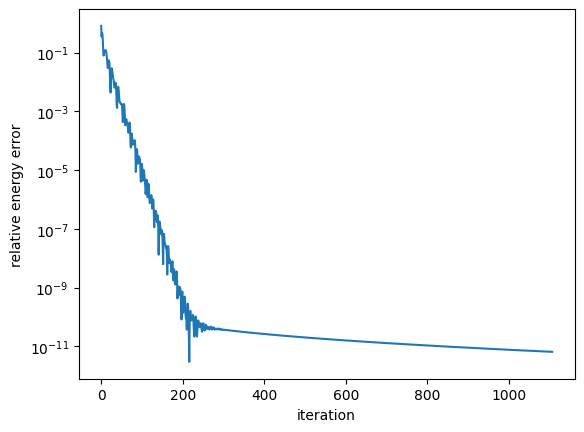

In [62]:
n = 4

critical_ham = TFI(n, 1, 0.5, periodic_x=True)
ge, gs = critical_ham.ground()
ham_mat = torch.tensor(critical_ham.matrix(dense=True))

num_layers = 2
num_params = 2 * num_layers
params = torch.tensor(np.random.rand(num_params))
cost_func = tfi_hva_energy
opt_kwargs = {'lr': 0.1, 'weight_decay': 1e-4}
sch_kwargs = {'mode': 'min', 'factor': 0.1, 'patience': 100}

context = RunContext(
            progress_interval=100,
            max_iter=10000,
            checkpoint_file=None,
            checkpoint_interval=100,
            resume=False,
            convergence_check=True,
            stop_ratio=1e-16
        )

energies, params = optimize_func(cost_func, params, (n, ham_mat), opt_kwargs=opt_kwargs, sch_kwargs=sch_kwargs, 
                                 context=context) 
cost_list = [np.abs(energy-ge)/np.abs(ge) for energy in energies]

plt.plot(cost_list)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('relative energy error')

In [42]:
n = 4
critical_ham = TFI(n, 1, 0.5, periodic_x=True)
ge, gs = critical_ham.ground()
ham_mat = torch.tensor(critical_ham.matrix(dense=True), dtype=torch.complex128)

num_layers = 3
num_params = 2 * num_layers
params = torch.tensor(np.random.rand(num_params), dtype=torch.float64, requires_grad=True)
np.abs(tfi_hva_energy(params, ham_mat, n).item() - ge)

array([2.10236839])

In [40]:
optimizer = torch.optim.SGD([params], lr=0.01)

num_iterations = 1000
cost_list = []
for _ in range(num_iterations):
    optimizer.zero_grad()
    loss = tfi_hva_energy(params, ham_mat, n)
    loss.backward()
    optimizer.step()
    cost_list.append(loss.item())

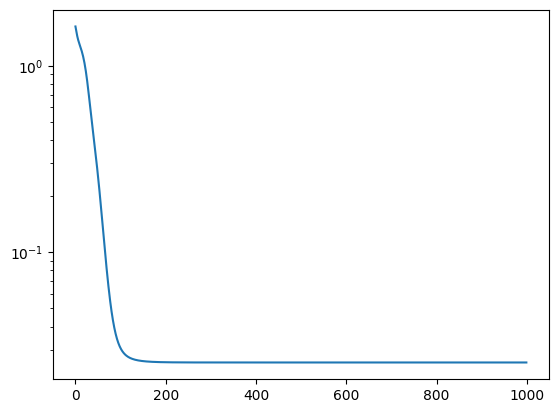

In [41]:
plt.plot([np.abs(c-ge) for c in cost_list])
plt.yscale('log')

In [18]:
ge, cost_list[-1]

(array([-1.18969262]), -1.1640119166944993)

In [20]:
print(tfi_hva(params, n))

H gate on site(s) [0] 
H gate on site(s) [1] 
H gate on site(s) [2] 
H gate on site(s) [3] 
R2 gate on site(s) [0, 1] 
R2 gate on site(s) [2, 3] 
R2 gate on site(s) [1, 2] 
R2 gate on site(s) [3, 0] 
R1 gate on site(s) [0] 
R1 gate on site(s) [1] 
R1 gate on site(s) [2] 
R1 gate on site(s) [3] 
R2 gate on site(s) [0, 1] 
R2 gate on site(s) [2, 3] 
R2 gate on site(s) [1, 2] 
R2 gate on site(s) [3, 0] 
R1 gate on site(s) [0] 
R1 gate on site(s) [1] 
R1 gate on site(s) [2] 
R1 gate on site(s) [3] 
R2 gate on site(s) [0, 1] 
R2 gate on site(s) [2, 3] 
R2 gate on site(s) [1, 2] 
R2 gate on site(s) [3, 0] 
R1 gate on site(s) [0] 
R1 gate on site(s) [1] 
R1 gate on site(s) [2] 
R1 gate on site(s) [3]


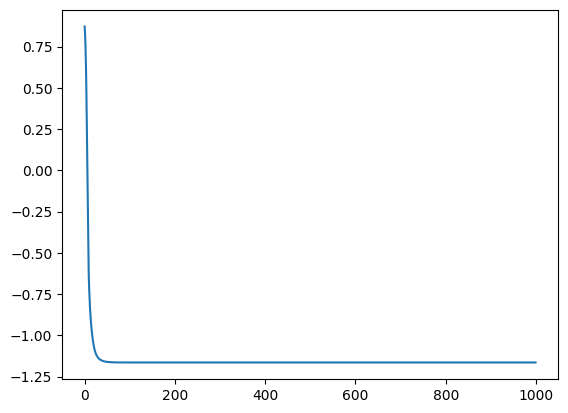

In [17]:
plt.plot(cost_list)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Plateau detected with cost 0.6757515578914528 at step 86


30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30


In [14]:
loss

tensor(-0.9793, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [12]:
n = 4

critical_ham = TFI(n, 1, 0.5)
ham_mat = torch.tensor(critical_ham.matrix(dense=True))

num_layers = 30
num_params = 2 * num_layers
#params = torch.tensor(np.random.rand(num_params))
params = torch.tensor(np.zeros(num_params))
cost_func = tfi_hva_energy
opt_kwargs = {'lr': 0.01, 'weight_decay': 1e-4}
sch_kwargs = {'mode': 'min', 'factor': 0.1, 'patience': 100}

cost_list, params = optimize_func(cost_func, params, (ham_mat, n), opt_kwargs=opt_kwargs, sch_kwargs=sch_kwargs) 
ge, tfi_hva_cost(params, n, target_sv).item(), tfi_hva_energy(params, ham_mat, n).item()

30
30
Plateau detected with cost 0.9999999999999993 at step 2
30
30


(array([-1.18969262]), 0.9966495900436616, 0.9999999999999993)

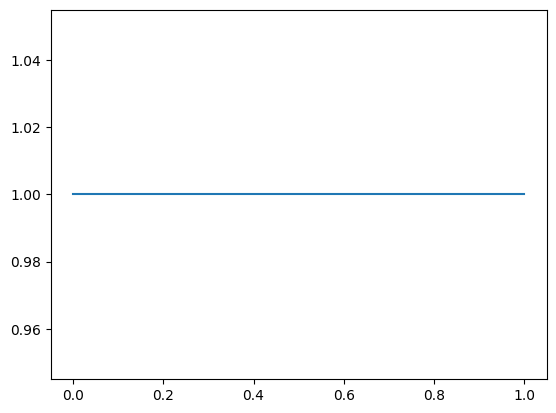

In [11]:
plt.plot(cost_list)
#plt.yscale('log')

In [69]:
n = 4

critical_ham = TFI(n, 1, 0.5)
ham_mat = torch.tensor(critical_ham.matrix(dense=True))

num_layers = 4
num_params = 2 * num_layers
params = torch.tensor(np.random.rand(num_params))
tfi_hva(params, n)

4


In [ ]:
max_overlap(target_sv, num_layers=8, lr=0.1, func=tfi_hva_cost, gamma=0.1, patience=200)

Step 10 at 2025-05-29T17:12:41 with cost 0.1483380099640862
Step 20 at 2025-05-29T17:12:41 with cost 0.06023261484331843
Step 30 at 2025-05-29T17:12:41 with cost 0.03272678179516164
Step 40 at 2025-05-29T17:12:41 with cost 0.022390432125282356
Step 50 at 2025-05-29T17:12:41 with cost 0.02381322294946797
Step 60 at 2025-05-29T17:12:41 with cost 0.021964064593009147
Step 70 at 2025-05-29T17:12:41 with cost 0.02191730018516269
Step 80 at 2025-05-29T17:12:42 with cost 0.021873214555673037
Step 90 at 2025-05-29T17:12:42 with cost 0.021843533866392928
Step 100 at 2025-05-29T17:12:42 with cost 0.02183686168332888
[Checkpoint saved at step 100]
Step 110 at 2025-05-29T17:12:42 with cost 0.0218384701844343
Step 120 at 2025-05-29T17:12:42 with cost 0.021834497640321082
Step 130 at 2025-05-29T17:12:42 with cost 0.021834863743278476
Step 140 at 2025-05-29T17:12:42 with cost 0.021834453194566783
Step 150 at 2025-05-29T17:12:42 with cost 0.021834334338576844
Step 160 at 2025-05-29T17:12:43 with cost 

KeyboardInterrupt: 

In [ ]:
n = 8
J = 1
h = 0.5
ham = TFI(n, J, h)
4*ham.ground()[0], (1-1/np.sin(np.pi / (4*n+2)))

(array([-9.83795145]), -9.837951447459421)

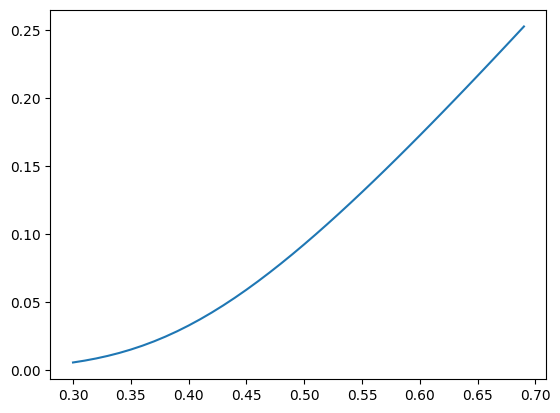

In [ ]:
h_range = np.arange(0.3,0.7,0.01)
J = 1

gap = []
for h in h_range: 
    ham = TFI(n, J, h)
    mat = ham.matrix(dense=True)
    evals = scipy.linalg.eigvalsh(mat)
    evals.sort()
    gap.append(evals[1] - evals[0])

import matplotlib.pyplot as plt 
plt.plot(h_range, gap, label='Exact Gap')

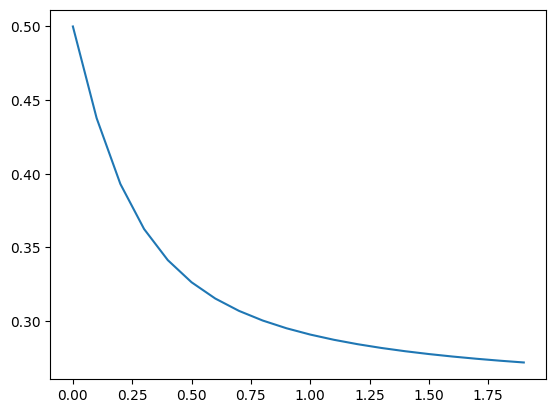

In [ ]:
h_range = np.arange(0,2,0.1)
J = 1

gap = []
for h in h_range: 
    ham = TFI(n, J, h)
    mat = ham.matrix(dense=True)
    evals = scipy.linalg.eigvalsh(mat)
    evals.sort()
    gap.append(evals[2] - evals[1])

import matplotlib.pyplot as plt 

plt.plot(h_range, gap, label='Exact Gap')

In [ ]:
ansatz[0].matrix, ansatz[1].matrix, ansatz[2].matrix, ansatz[3].matrix

(array([[0.99856723-0.05351159j, 0.        +0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.99856723+0.05351159j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.99856723+0.05351159j, 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 0.99856723-0.05351159j]]),
 array([[0.99856723-0.05351159j, 0.        +0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.99856723+0.05351159j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.99856723+0.05351159j, 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 0.99856723-0.05351159j]]),
 array([[0.8897501-0.45644798j, 0.       +0.j        ,
         0.       +0.

In [ ]:
# hva 

def hva_layer(ham, odd_angle, even_angle):
    """
    torch-aware HVA layer construction.
    uses different unitary matrices for even and odd triangle indices,
    and adapts to NumPy or Torch backends based on input types.
    """
    backend = "torch" if torch.is_tensor(odd_angle) or torch.is_tensor(even_angle) else "numpy"
    expm = scipy.linalg.expm if backend == "numpy" else torch.linalg.matrix_exp

    tmat_np, _ = ham.primitive_matrices()
    tmat = tmat_np if backend == "numpy" else torch.tensor(tmat_np, dtype=odd_angle.dtype)

    even_unitary = expm(-1j * even_angle * tmat)
    odd_unitary = expm(-1j * odd_angle * tmat)

    triangles = sorted(list(ham.lattice.triangle_terms))
    gate_list = [Gate("triangle", tri, even_unitary) for tri in triangles[::2]] + \
                [Gate("triangle", tri, odd_unitary) for tri in triangles[1::2]]
    
    return gate_list

def hva_circ(params, ham): 
    """ return Circuit built from several layers of HVA gates """
    gate_list = [] 
    for i in range(len(params)//2): 
        gate_list += hva_layer(ham, params[2*i], params[2*i+1])

    return Circuit(gate_list)

def hva_cost(params, ham, target_sv, init_state): 
    """ return cost function for HVA circuit """
    circ = hva_circ(params, ham)
    sim = StatevectorSim(circ, init_state=init_state, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return 1 - torch.abs(torch.dot(ansatz_sv.conj(), target_sv))**2

def generic_cost(params, ham, target_sv): 
    """ return cost function for generic circuit """
    num_sites = ham.num_sites
    num_layers = len(params) // (15*(num_sites-1))
    skeleton = brickwall_skeleton(num_sites, num_layers)

    circ = two_local_circ(skeleton, params)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return 1 - torch.abs(torch.dot(ansatz_sv.conj(), target_sv))**2

def max_overlap(ham, target_sv, init_state, num_layers=2, lr=0.05, func=hva_cost, gamma=0.1, patience=200):
    num_params = num_layers * 2 if func == hva_cost else 15 * (ham.num_sites - 1) * num_layers
    params = torch.nn.Parameter(torch.randn(num_params))
    optimizer = torch.optim.AdamW([params], lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',             
        factor=gamma,           
        patience=patience,      
        threshold=1e-4,         
        threshold_mode='rel'
    )

    context = RunContext(
        progress_interval=10,
        max_iter=10000,
        checkpoint_file="hva_checkpoint.pickle",
        checkpoint_interval=100,
        resume=False,
        convergence_check=True,
        stop_ratio=1e-18,
        stop_absolute=1e-7
    )

    cost_list = []
    run_state = {
        "cost_list": cost_list,
        "step": context.step
    }

    while True:
        cost = func(params, ham, target_sv, init_state)
        cost_val = cost.item()
        cost_list.append(cost_val)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(cost_val)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"[LR Drop] Step {run_state['step']}: cost = {cost:.2e}, LR dropped from {old_lr:.2e} to {new_lr:.2e}")

        run_state["step"] += 1
        run_state["cost_list"] = cost_list

        if context.step_update(run_state): 
            break

    return cost_list, params

In [ ]:
# quantum numbers

def total_sz(num_sites):
    """Compute the total S^z operator for a system of qubits."""
    total_z = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
    for i in range(num_sites):
        op = embed_operator(num_sites, [i], [pauli_Z], dense=True, factor=True)
        total_z += op
    return total_z

def total_spin(num_sites):
    """Compute the total spin operators S^x, S^y, S^z."""
    total_x = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
    total_y = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
    total_z = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
    
    for i in range(num_sites):
        total_x += embed_operator(num_sites, [i], [pauli_X], dense=True, factor=True)
        total_y += embed_operator(num_sites, [i], [pauli_Y], dense=True, factor=True)
        total_z += embed_operator(num_sites, [i], [pauli_Z], dense=True, factor=True)
        
    return total_x, total_y, total_z

def total_spin_squared(num_sites):
    """Compute the total spin squared operator S^2 = S_x^2 + S_y^2 + S_z^2."""
    sx, sy, sz = total_spin(num_sites)
    return sx @ sx + sy @ sy + sz @ sz

In [ ]:
row_layout = [{'num_cells': 1, 'shift': 0.0}, 
             {'num_cells': 2, 'shift': -0.5}, 
             {'num_cells': 3, 'shift': -1}]
sp = [0,1,9,11,16,17]
ham = ChiralHeisenberg(row_layout=row_layout, sp=sp)
#ham.lattice.plot()

true_ge, true_gs = ham.ground()

KeyboardInterrupt: 

In [ ]:
Sz = total_sz(ham.num_sites)
Ssq = total_spin_squared(ham.num_sites)

print(true_gs.conj().T @ Sz @ true_gs, true_gs.conj().T @ Ssq @ true_gs)

singlet = (1/np.sqrt(2)) * (string_to_sv("01", local_dim=2) - string_to_sv("10", local_dim=2))
singlet_12 = reduce(np.kron, [singlet]*6)
singlet_12.conj().T @ Sz @ singlet_12, singlet_12.conj().T @ Ssq @ singlet_12

NameError: name 'total_sz' is not defined

In [ ]:
len(torch.tensor(np.random.rand(5)))

5

In [ ]:
true_gs_torch = torch.tensor(true_gs[:,0], dtype=torch.complex128)
singlet_12_torch = torch.tensor(singlet_12, dtype=torch.complex128)
cost_list, params = max_overlap(ham, true_gs_torch, singlet_12_torch, num_layers=40, lr=0.1, func=hva_cost, gamma=0.1, patience=200)

Step 10 at 2025-05-29T14:10:30 with cost 0.9906476579071452
Step 20 at 2025-05-29T14:10:35 with cost 0.9910933848443123
Step 30 at 2025-05-29T14:10:39 with cost 0.9904819539264139
Step 40 at 2025-05-29T14:10:43 with cost 0.9897719091026365
Step 50 at 2025-05-29T14:10:48 with cost 0.9895631742376696
Step 60 at 2025-05-29T14:10:52 with cost 0.9894010943337259
Step 70 at 2025-05-29T14:10:57 with cost 0.9896667651854404
Step 80 at 2025-05-29T14:11:01 with cost 0.9893569955241968
Step 90 at 2025-05-29T14:11:05 with cost 0.989224419766928
Step 100 at 2025-05-29T14:11:10 with cost 0.9892116786953112
[Checkpoint saved at step 100]
Step 110 at 2025-05-29T14:11:14 with cost 0.9891898930544462
Step 120 at 2025-05-29T14:11:18 with cost 0.9891793611202772
Step 130 at 2025-05-29T14:11:23 with cost 0.98923803588925
Step 140 at 2025-05-29T14:11:27 with cost 0.9894680131343013
Step 150 at 2025-05-29T14:11:32 with cost 0.9893352704536393
Step 160 at 2025-05-29T14:11:36 with cost 0.9891625590023173
Step 

KeyboardInterrupt: 

In [ ]:
from functools import reduce

#singlet.conj().T @ total_sz(2) @ singlet, singlet.conj().T @ total_spin_squared(2) @ singlet

In [ ]:
#target = random_sv(ham.num_sites) 

circ = Circuit([H(0), CNOT([1,0]), CNOT([2,1]), CNOT([3,2]), CNOT([4,3]), CNOT([5,4]), CNOT([6,5]), CNOT([7,6]), CNOT([8,7]), CNOT([9,8]), CNOT([10, 9]), CNOT([11,10])])
target = circ.to_matrix() @ all_zero_sv(ham.num_sites, dense=True)
target = torch.tensor(target, dtype=torch.complex128)

In [ ]:
target.shape

torch.Size([4096])

Step 10 at 2025-05-22T14:12:24 with cost 0.499997829977581
Step 20 at 2025-05-22T14:12:26 with cost 0.4999982083286978
Step 30 at 2025-05-22T14:12:28 with cost 0.4999950855283354
Step 40 at 2025-05-22T14:12:30 with cost 0.4999952723398755
Step 50 at 2025-05-22T14:12:33 with cost 0.49999479132584757
Step 60 at 2025-05-22T14:12:35 with cost 0.4999929474504522
Step 70 at 2025-05-22T14:12:37 with cost 0.49999068666133106
Step 80 at 2025-05-22T14:12:39 with cost 0.49999315993893767
Step 90 at 2025-05-22T14:12:41 with cost 0.49998902011694013
Step 100 at 2025-05-22T14:12:44 with cost 0.49999493019057295
[Checkpoint saved at step 100]
Step 110 at 2025-05-22T14:12:46 with cost 0.49998799653079784
Step 120 at 2025-05-22T14:12:48 with cost 0.4999933225317509
Step 130 at 2025-05-22T14:12:50 with cost 0.4999943612747926
Step 140 at 2025-05-22T14:12:52 with cost 0.4999947689062705
Step 150 at 2025-05-22T14:12:55 with cost 0.49999462673364226
Step 160 at 2025-05-22T14:12:57 with cost 0.4999901041570

KeyboardInterrupt: 

Fitted slope: -1.0061233256528448


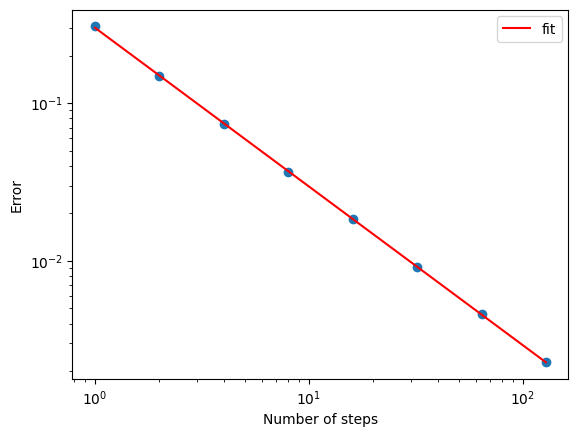

In [ ]:
# testing hva_circ() by confirming Trotter error

time = 1
init_state = random_sv(ham.num_sites)
final_state = ham.evolve(time, init_state)

step_opts = [1, 2, 4, 8, 16, 32, 64, 128]
err_list = []
for num_steps in step_opts:
    step_size = time / num_steps
    params = [step_size] * num_steps * 2
    circ = hva_circ(params, ham)

    sim = StatevectorSim(circ, init_state=init_state)
    trotter_state = sim.run(progress_bar=False).reshape(2**ham.num_sites)
    error = np.linalg.norm(trotter_state - final_state)
    err_list.append(error)

log_err = np.log(err_list)
log_step = np.log(step_opts)
slope, intercept = np.polyfit(log_step, log_err, 1)
print(f"Fitted slope: {slope}")

plt.scatter(step_opts, err_list)
plt.plot(step_opts, np.exp(intercept) * np.array(step_opts)**slope, label='fit', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of steps')
plt.ylabel('Error')
plt.legend()

In [ ]:
num_layers = 4
params = np.random.rand(num_layers * 2) * 2 
hva_cost(params, ham, true_gs)

1.0

In [ ]:
# set up ansatz and optimizer
num_layers = 2
skeleton = brickwall_skeleton(n, num_layers)
params = torch.nn.Parameter(torch.randn(15*len(skeleton)))
optimizer = torch.optim.Adam([params], lr=0.05)


# set up RunContext for logging, checkpointing, and stopping
context = RunContext(
    progress_interval=10,
    max_iter=10000,
    checkpoint_file="checkpoint.pickle",
    checkpoint_interval=100,
    resume=False,
    convergence_check=True,
    stop_ratio=1e-8, 
    stop_absolute=1e-7
)

# initialize the state of the run
cost_list = []
run_state = {
    "cost_list": cost_list,
    "step": context.step
}

while True: 
    cost = infidelity(params, skeleton, target_sv)
    cost_list.append(cost.item())
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Update run state
    run_state["step"] += 1
    run_state["cost_list"] = cost_list

    # Let RunContext handle logging, checkpointing, and stopping
    if context.step_update(run_state):
        print(f"Terminating at step {run_state['step']} with cost {cost_list[-1]}")
        break

In [ ]:

def max_overlap(target_sv, num_layers=2, lr=0.05, func=tfi_hva_cost, gamma=0.1, patience=200):
    num_sites = int(np.log2(len(target_sv)))
    num_params = num_layers * 2 if func == tfi_hva_cost else num_layers
    params = torch.nn.Parameter(torch.randn(num_params))
    optimizer = torch.optim.AdamW([params], lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',             
        factor=gamma,           
        patience=patience,      
        threshold=1e-4,         
        threshold_mode='rel'
    )

    context = RunContext(
        progress_interval=10,
        max_iter=10000,
        checkpoint_file="hva_checkpoint.pickle",
        checkpoint_interval=100,
        resume=False,
        convergence_check=True,
        stop_ratio=1e-18,
        stop_absolute=1e-7
    )

    cost_list = []
    run_state = {
        "cost_list": cost_list,
        "step": context.step
    }

    while True:
        cost = func(params, num_sites, target_sv)
        cost_val = cost.item()
        cost_list.append(cost_val)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(cost_val)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"[LR Drop] Step {run_state['step']}: cost = {cost:.2e}, LR dropped from {old_lr:.2e} to {new_lr:.2e}")

        run_state["step"] += 1
        run_state["cost_list"] = cost_list

        if context.step_update(run_state): 
            break

    return cost_list, params